# Softmax exercise
(Adapted from Stanford University's CS231n Open Courseware)

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [HW page](http://kovan.ceng.metu.edu.tr/~sinan/DL/index.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=18000, num_validation=1000, num_test=1000):
#Increase training if you have memory:
#def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir,num_of_batches=3)
# Increase num_of_batches to 6 if you have sufficient memory
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
  
  return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (3073, 18000)
Train labels shape:  (18000,)
Validation data shape:  (3073, 1000)
Validation labels shape:  (1000,)
Test data shape:  (3073, 1000)
Test labels shape:  (1000,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(10, 3073) * 0.0001
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.354793
sanity check: 2.302585


# Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *When chosing random, we have a probability of 0.1 for finding correct class. 
Given the softmax loss equation, **-** Sum( **p**log(**q**)), q is the corresponding prabability.*


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.499399 analytic: -0.499399, relative error: 8.701864e-10
numerical: -0.780079 analytic: -0.780079, relative error: 5.217726e-08
numerical: -1.905503 analytic: -1.905503, relative error: 3.062493e-08
numerical: 0.102524 analytic: 0.102524, relative error: 2.449149e-07
numerical: 2.812118 analytic: 2.812118, relative error: 1.331430e-08
numerical: -2.360736 analytic: -2.360736, relative error: 6.726596e-09
numerical: 0.388888 analytic: 0.388888, relative error: 1.022738e-07
numerical: 0.701979 analytic: 0.701979, relative error: 5.008245e-08
numerical: 0.802914 analytic: 0.802914, relative error: 1.075133e-08
numerical: -1.759194 analytic: -1.759194, relative error: 4.042086e-09


In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.354793e+00 computed in 2.710691s
vectorized loss: 2.354793e+00 computed in 0.264169s
Loss difference: 0.000000
Gradient difference: 0.000000


In [24]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
#learning_rates = [ 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
#regularization_strengths = [ 1e-1, 2e-2, 5e-2, 8e-2, 1e-2, 2e-3, 5e-3, 7e-3, 1e-3]
learning_rates = [12e-7, 13e-7, 14e-7]
regularization_strengths = [27e3, 272e2, 275e2]
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for rg in regularization_strengths:
        softmax = Softmax()
        loss_history = softmax.train(X = X_train, y = y_train, learning_rate = lr, reg = rg, num_iters=100)
        y_pred_train = softmax.predict(X_train)
        y_pred_val = softmax.predict(X_val)
        
        dummy = np.zeros_like(y_val)
        dummy[ y_pred_val == y_val ] = 1
        acc_val = np.sum(dummy)/float(y_val.shape[0])
        if acc_val > best_val:
            best_val = acc_val
            best_softmax = softmax
            
        dummy = np.zeros_like(y_train)
        dummy[ y_pred_train == y_train ] = 1
        acc_train = np.sum(dummy)/float(y_train.shape[0])
        
        results[(lr, rg)] = acc_train, acc_val
    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.200000e-06 reg 2.700000e+04 train accuracy: 0.331889 val accuracy: 0.328000
lr 1.200000e-06 reg 2.720000e+04 train accuracy: 0.338944 val accuracy: 0.340000
lr 1.200000e-06 reg 2.750000e+04 train accuracy: 0.335833 val accuracy: 0.331000
lr 1.300000e-06 reg 2.700000e+04 train accuracy: 0.338389 val accuracy: 0.338000
lr 1.300000e-06 reg 2.720000e+04 train accuracy: 0.342778 val accuracy: 0.350000
lr 1.300000e-06 reg 2.750000e+04 train accuracy: 0.329556 val accuracy: 0.321000
lr 1.400000e-06 reg 2.700000e+04 train accuracy: 0.335056 val accuracy: 0.335000
lr 1.400000e-06 reg 2.720000e+04 train accuracy: 0.343444 val accuracy: 0.347000
lr 1.400000e-06 reg 2.750000e+04 train accuracy: 0.343333 val accuracy: 0.347000
best validation accuracy achieved during cross-validation: 0.350000


In [25]:
# evaluate on test set
# Evaluate the best svm on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.351000


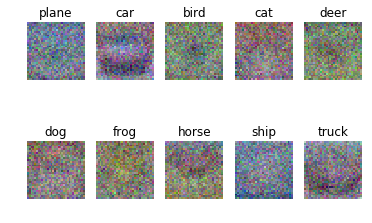

In [26]:
# Visualize the learned weights for each class
w = best_softmax.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])